In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd

In [2]:
# Setup plotting
plotting.setup_mpl()

# Enable the cache
ff1.Cache.enable_cache(r'D:\789\f1\winter test 2023') 


# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None 

In [17]:
# Load the session data
test2023_1_day = ff1.get_testing_session(2023, 1, 1)

In [18]:
test2023_2_day = ff1.get_testing_session(2023, 1, 2)

In [19]:
test2023_3_day = ff1.get_testing_session(2023, 1, 3)

In [20]:
laps_1_day = test2023_1_day.load_laps()

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Pre-Season Testing - Practice 1 [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['1', '63', '55', '44', '34', '31', '27', '24', '77', '23', '21', '20', '16', '14', '10', '4', '2', '22', '81']


In [21]:
laps_2_day = test2023_2_day.load_laps()

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Pre-Season Testing - Practice 2 [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 17 drivers: ['1', '55', '44', '31', '27', '24', '22', '63', '21', '16', '14', '11', '10', '4', '2', '20', '81']


In [22]:
laps_3_day = test2023_3_day.load_laps()

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Pre-Season Testing - Practice 3 [v2.3.0]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api         WARNING 	Driver 10: Ignoring late data for a previously processed lap.The data may contain errors (previous: 56; current 57)
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api 

In [140]:
# Convert laptimes to seconds
laps_1_day['LapTimeSeconds'] = laps_1_day['LapTime'].dt.total_seconds()
laps_2_day['LapTimeSeconds'] = laps_2_day['LapTime'].dt.total_seconds()
laps_3_day['LapTimeSeconds'] = laps_3_day['LapTime'].dt.total_seconds()


In [27]:
q75, q25 = laps_1_day['LapTimeSeconds'].quantile(0.75), laps_1_day['LapTimeSeconds'].quantile(0.25)

intr_qr = q75 - q25

laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR

laps.loc[laps_1_day['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps_1_day['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [115]:
drivers_to_visualize_1_day_1 = ['ALB','ZHO' , 'MAG', 'LEC', 'ALO', 'GAS','HAM',  'TSU', 'PIA']

In [116]:
drivers_to_visualize_1_day_2 = ['VER', 'RUS', 'SAI', 'NOR', 'DRU', 'OCO', 'HUL', 'DEV', 'BOT', 'SAR']

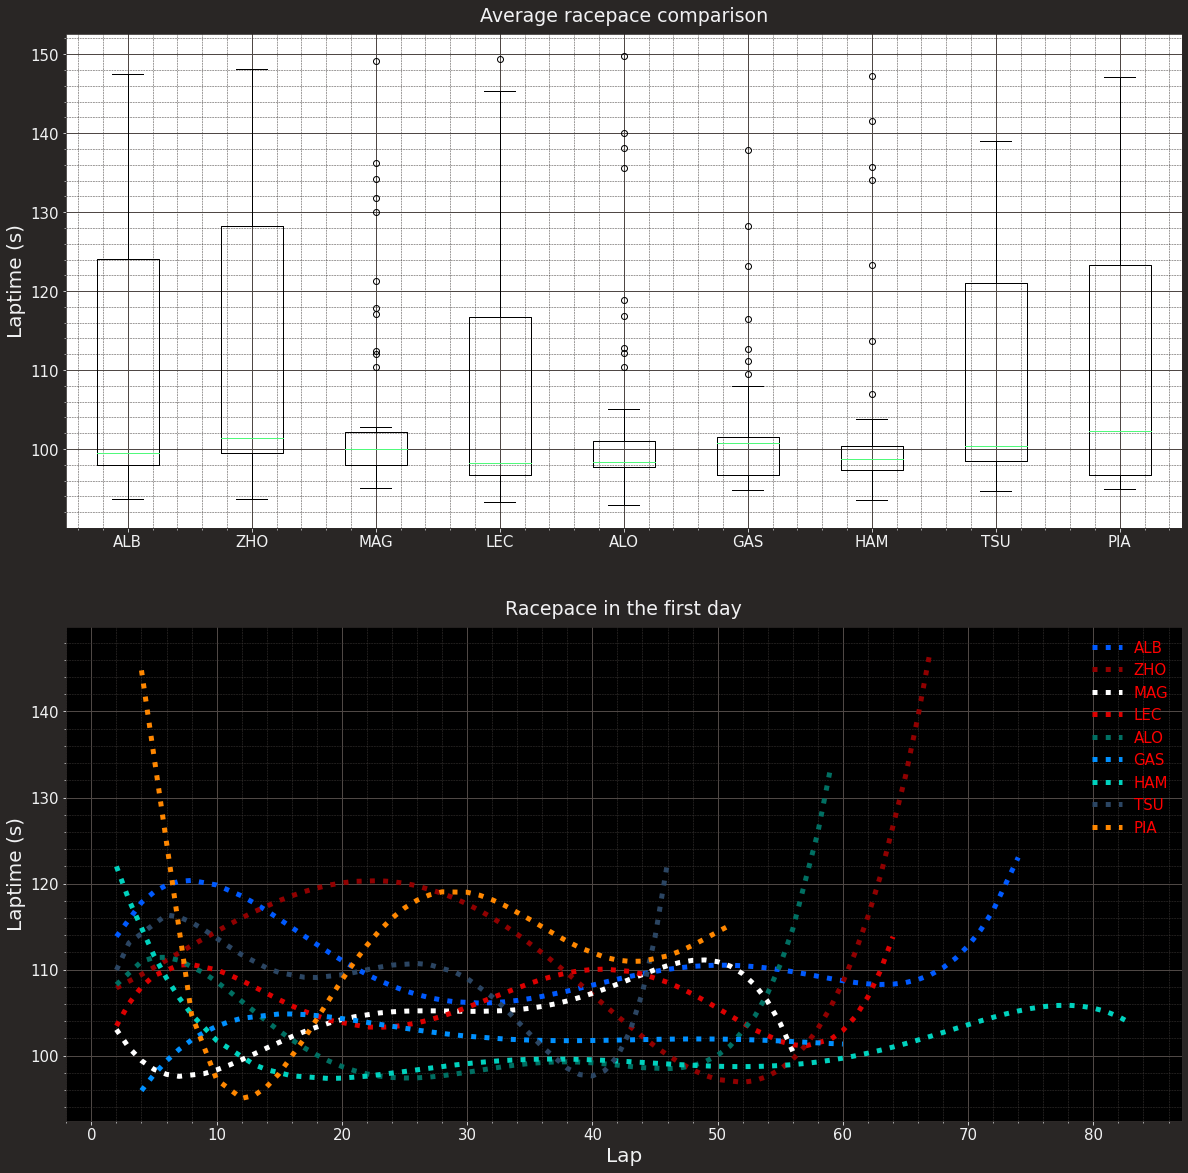

In [118]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams_1_day_1 = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [20, 20]
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)

##############################
# Boxplot for average racepace
##############################
laptimes = [laps_1_day.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize_1_day_1] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize_1_day_1)

ax[0].set_title('Average racepace comparison')
ax[0].set_ylabel('Laptime (s)', fontsize = 20)

##############################
# Lap-by-lap racepace comparison
###############

for driver in drivers_to_visualize_1_day_1:
    driver_laps = laps_1_day.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle, linewidth = 5)
    
    # Append labels
    ax[1].set_ylabel('Laptime (s)', fontsize = 20)
    ax[1].set_xlabel('Lap', fontsize = 20)
    
    # Set facecolor
    ax[0].set_facecolor('white')
    ax[1].set_facecolor('black')
    
    #Set ticksize
    ax[0].xaxis.set_tick_params(labelsize = 15)
    ax[0].yaxis.set_tick_params(labelsize = 15)
    ax[1].xaxis.set_tick_params(labelsize = 15)
    ax[1].yaxis.set_tick_params(labelsize = 15)
    
    # Set title
    ax[1].set_title('Racepace in the first day')

    # Generate legend
    ax[1].legend(framealpha=1, fontsize = 15, labelcolor = 'red', facecolor = 'lightblue', frameon = False)
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

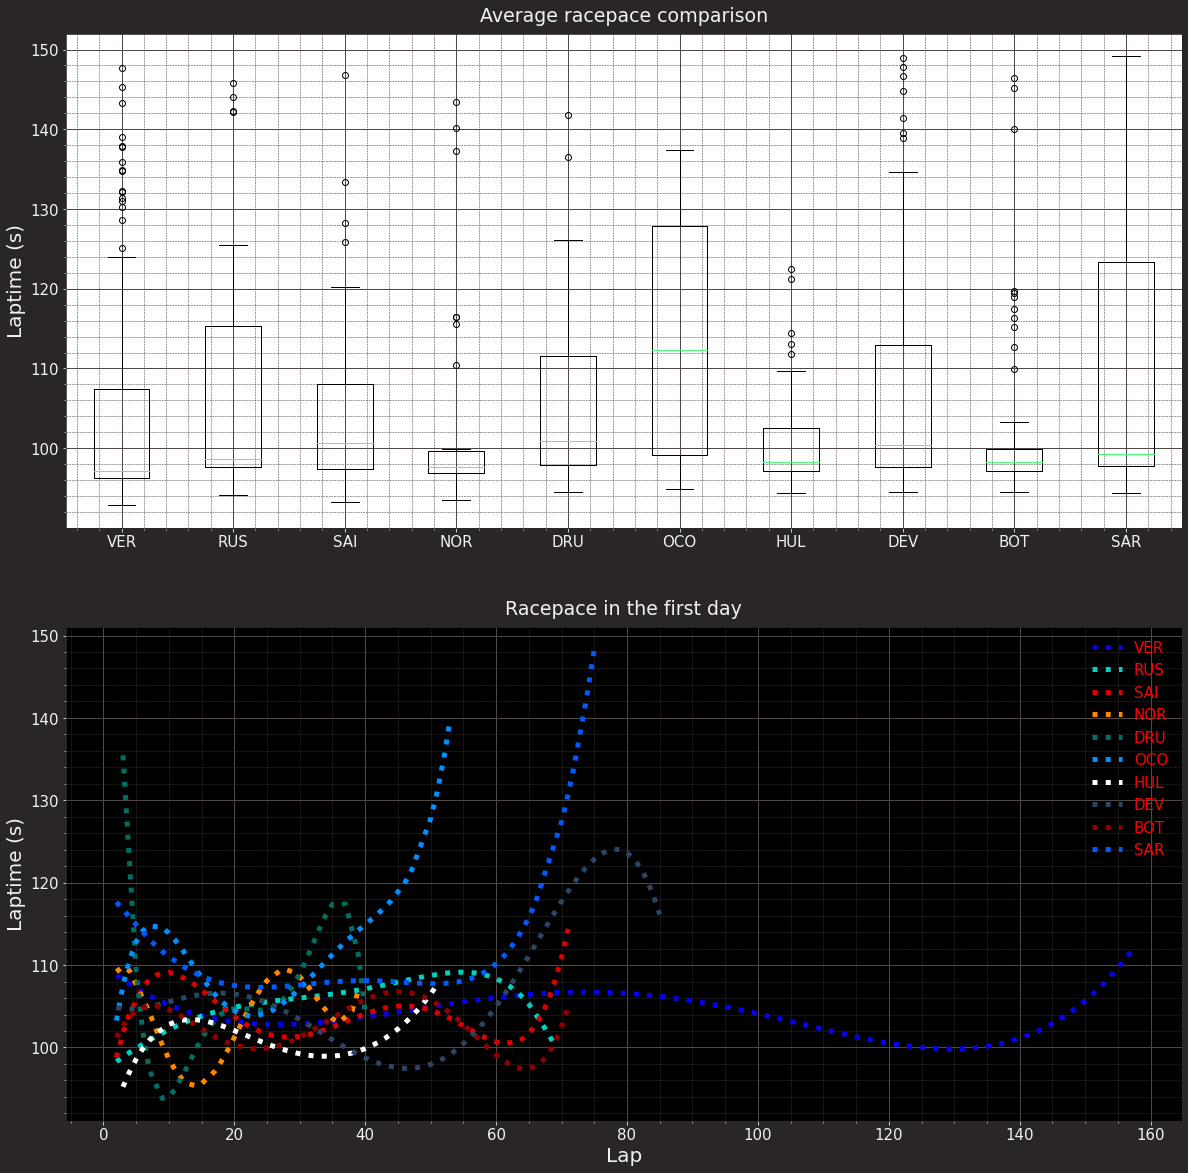

In [119]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams_1_day_2 = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [20, 20]
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)

##############################
# Boxplot for average racepace
##############################
laptimes = [laps_1_day.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize_1_day_2] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize_1_day_2)

ax[0].set_title('Average racepace comparison')
ax[0].set_ylabel('Laptime (s)', fontsize = 20)

##############################
# Lap-by-lap racepace comparison
###############

for driver in drivers_to_visualize_1_day_2:
    driver_laps = laps_1_day.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle, linewidth = 5)
    
    # Append labels
    ax[1].set_ylabel('Laptime (s)', fontsize = 20)
    ax[1].set_xlabel('Lap', fontsize = 20)
    
    # Set facecolor
    ax[0].set_facecolor('white')
    ax[1].set_facecolor('black')
    
    #Set ticksize
    ax[0].xaxis.set_tick_params(labelsize = 15)
    ax[0].yaxis.set_tick_params(labelsize = 15)
    ax[1].xaxis.set_tick_params(labelsize = 15)
    ax[1].yaxis.set_tick_params(labelsize = 15)
    
    # Set title
    ax[1].set_title('Racepace in the first day')

    # Generate legend
    ax[1].legend(framealpha=1, fontsize = 15, labelcolor = 'red', facecolor = 'lightblue', frameon = False)
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

In [137]:
drivers_to_visualize_2_day_1 = ['PER','ZHO' , 'MAG', 'LEC', 'ALO', 'GAS','HAM',  'TSU', 'PIA']
drivers_to_visualize_2_day_2 = ['VER', 'RUS', 'SAI', 'NOR', 'OCO', 'HUL', 'DEV', 'SAR']


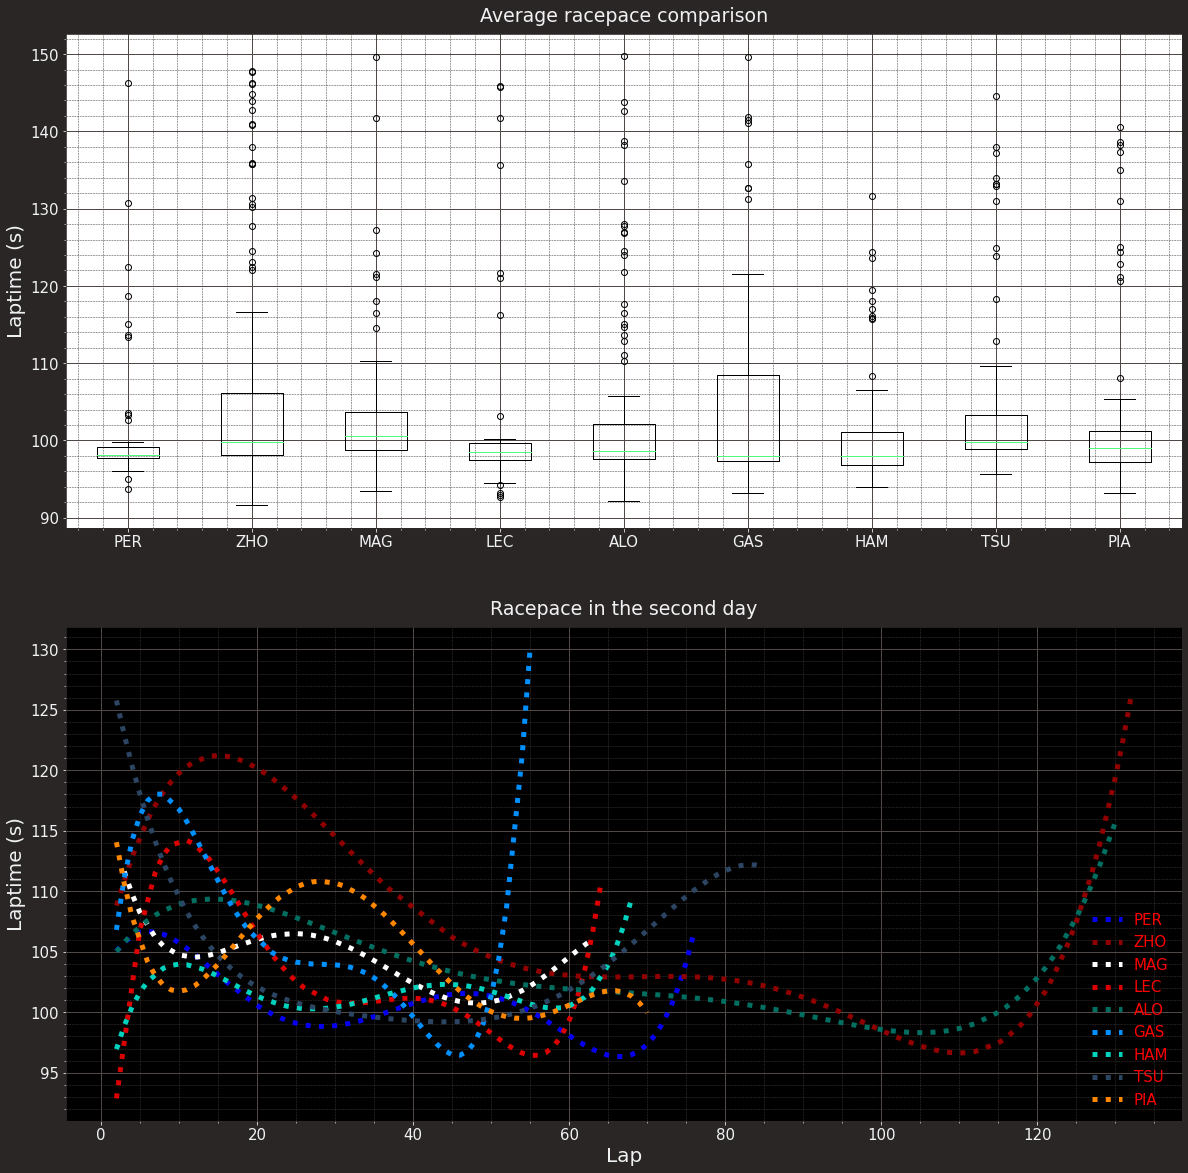

In [141]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams_2_day_1 = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [20, 20]
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)

##############################
# Boxplot for average racepace
##############################
laptimes = [laps_2_day.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize_2_day_1] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize_2_day_1)

ax[0].set_title('Average racepace comparison')
ax[0].set_ylabel('Laptime (s)', fontsize = 20)

##############################
# Lap-by-lap racepace comparison
###############

for driver in drivers_to_visualize_2_day_1:
    driver_laps = laps_2_day.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle, linewidth = 5)
    
    # Append labels
    ax[1].set_ylabel('Laptime (s)', fontsize = 20)
    ax[1].set_xlabel('Lap', fontsize = 20)
    
    # Set facecolor
    ax[0].set_facecolor('white')
    ax[1].set_facecolor('black')
    
    #Set ticksize
    ax[0].xaxis.set_tick_params(labelsize = 15)
    ax[0].yaxis.set_tick_params(labelsize = 15)
    ax[1].xaxis.set_tick_params(labelsize = 15)
    ax[1].yaxis.set_tick_params(labelsize = 15)
    
    # Set title
    ax[1].set_title('Racepace in the second day')

    # Generate legend
    ax[1].legend(framealpha=1, fontsize = 15, labelcolor = 'red', facecolor = 'lightblue', frameon = False)
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)
    

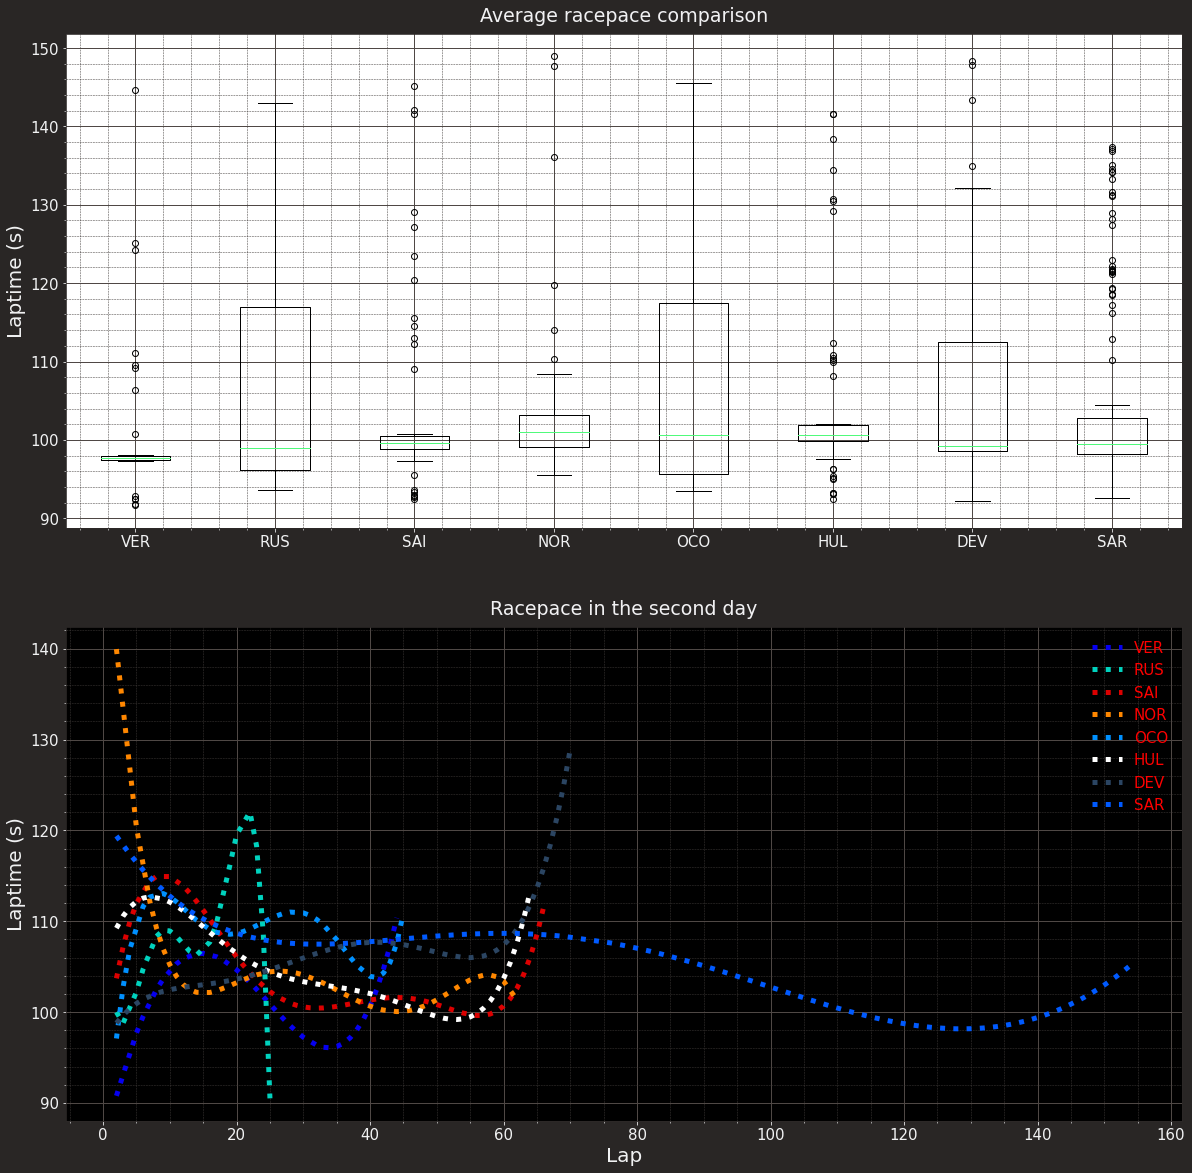

In [142]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams_2_day_2 = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [20, 20]
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)

##############################
# Boxplot for average racepace
##############################
laptimes = [laps_2_day.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize_2_day_2] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize_2_day_2)

ax[0].set_title('Average racepace comparison')
ax[0].set_ylabel('Laptime (s)', fontsize = 20)

##############################
# Lap-by-lap racepace comparison
###############

for driver in drivers_to_visualize_2_day_2:
    driver_laps = laps_2_day.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle, linewidth = 5)
    
    # Append labels
    ax[1].set_ylabel('Laptime (s)', fontsize = 20)
    ax[1].set_xlabel('Lap', fontsize = 20)
    
    # Set facecolor
    ax[0].set_facecolor('white')
    ax[1].set_facecolor('black')
    
    #Set ticksize
    ax[0].xaxis.set_tick_params(labelsize = 15)
    ax[0].yaxis.set_tick_params(labelsize = 15)
    ax[1].xaxis.set_tick_params(labelsize = 15)
    ax[1].yaxis.set_tick_params(labelsize = 15)
    
    # Set title
    ax[1].set_title('Racepace in the second day')

    # Generate legend
    ax[1].legend(framealpha=1, fontsize = 15, labelcolor = 'red', facecolor = 'lightblue', frameon = False)
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

In [144]:
drivers_to_visualize_3_day_1 = ['PER','MAG', 'LEC', 'ALO', 'GAS','HAM',  'TSU', 'PIA', 'ALB']
drivers_to_visualize_3_day_2 = ['BOT', 'RUS', 'SAI', 'NOR', 'OCO', 'HUL', 'DEV', 'DRU']


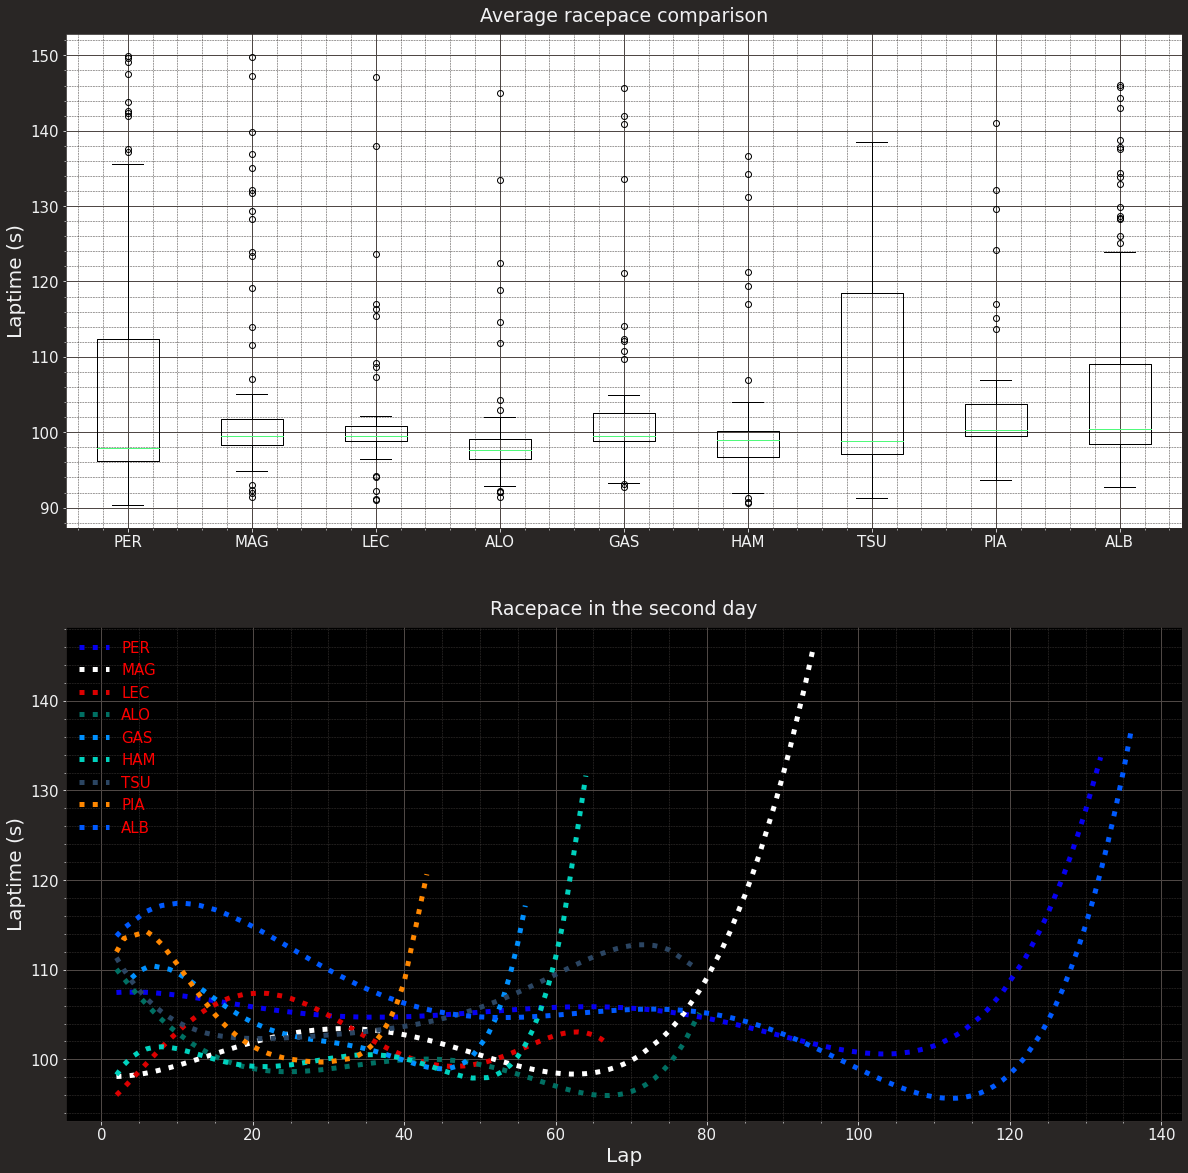

In [146]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams_3_day_1 = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [20, 20]
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)

##############################
# Boxplot for average racepace
##############################
laptimes = [laps_3_day.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize_3_day_1] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize_3_day_1)

ax[0].set_title('Average racepace comparison')
ax[0].set_ylabel('Laptime (s)', fontsize = 20)

##############################
# Lap-by-lap racepace comparison
###############

for driver in drivers_to_visualize_3_day_1:
    driver_laps = laps_3_day.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle, linewidth = 5)
    
    # Append labels
    ax[1].set_ylabel('Laptime (s)', fontsize = 20)
    ax[1].set_xlabel('Lap', fontsize = 20)
    
    # Set facecolor
    ax[0].set_facecolor('white')
    ax[1].set_facecolor('black')
    
    #Set ticksize
    ax[0].xaxis.set_tick_params(labelsize = 15)
    ax[0].yaxis.set_tick_params(labelsize = 15)
    ax[1].xaxis.set_tick_params(labelsize = 15)
    ax[1].yaxis.set_tick_params(labelsize = 15)
    
    # Set title
    ax[1].set_title('Racepace in the third day')

    # Generate legend
    ax[1].legend(framealpha=1, fontsize = 15, labelcolor = 'red', facecolor = 'lightblue', frameon = False)
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

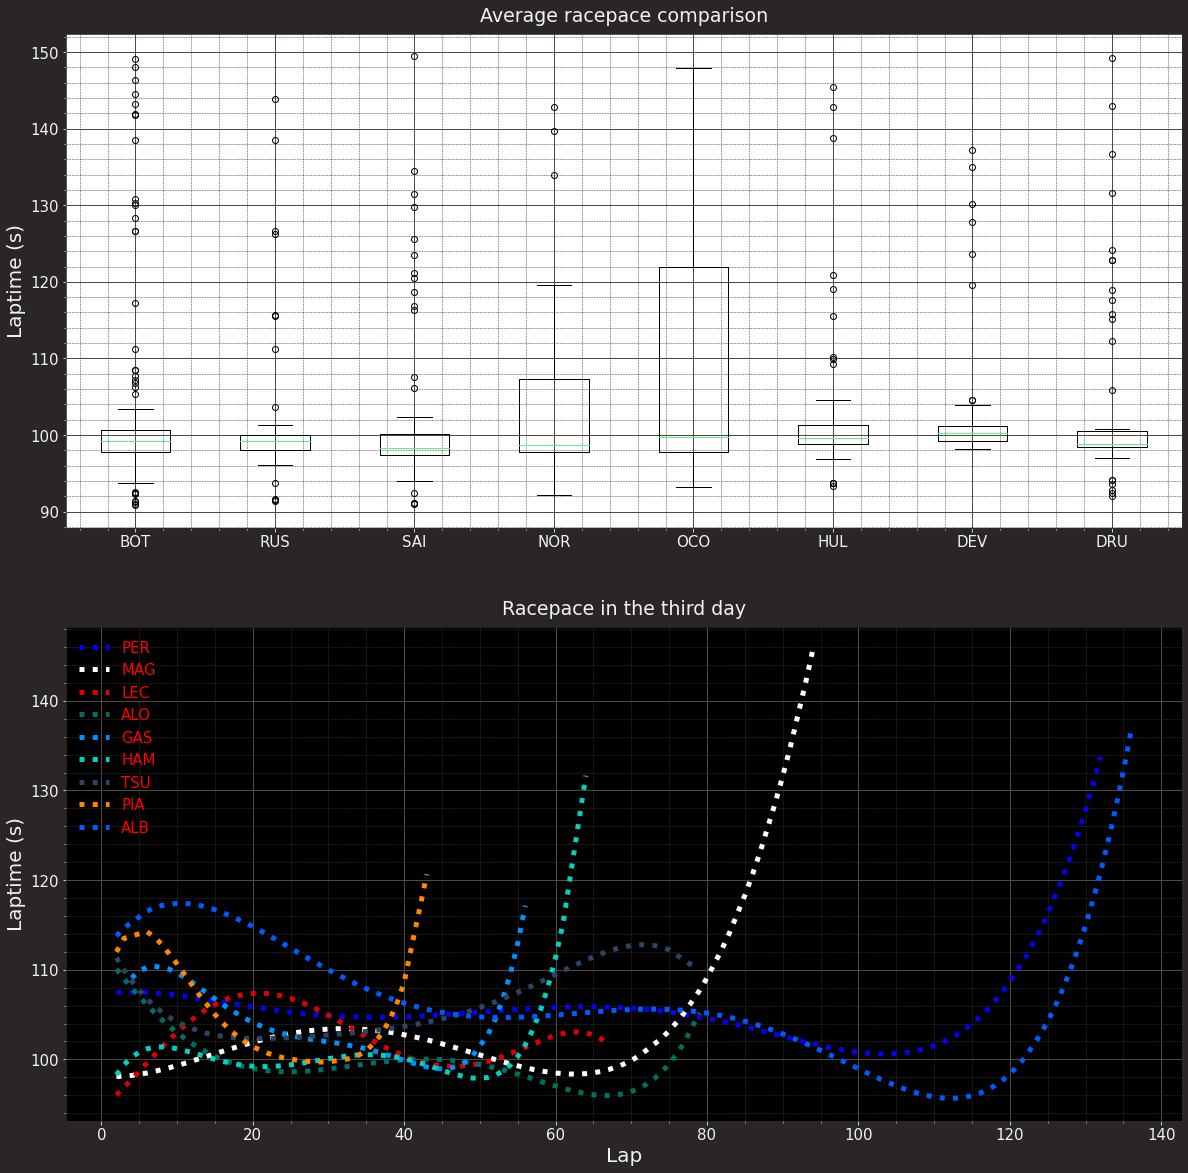

In [147]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams_3_day_2 = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [20, 20]
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)

##############################
# Boxplot for average racepace
##############################
laptimes = [laps_3_day.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize_3_day_2] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize_3_day_2)

ax[0].set_title('Average racepace comparison')
ax[0].set_ylabel('Laptime (s)', fontsize = 20)

##############################
# Lap-by-lap racepace comparison
###############

for driver in drivers_to_visualize_3_day_1:
    driver_laps = laps_3_day.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle, linewidth = 5)
    
    # Append labels
    ax[1].set_ylabel('Laptime (s)', fontsize = 20)
    ax[1].set_xlabel('Lap', fontsize = 20)
    
    # Set facecolor
    ax[0].set_facecolor('white')
    ax[1].set_facecolor('black')
    
    #Set ticksize
    ax[0].xaxis.set_tick_params(labelsize = 15)
    ax[0].yaxis.set_tick_params(labelsize = 15)
    ax[1].xaxis.set_tick_params(labelsize = 15)
    ax[1].yaxis.set_tick_params(labelsize = 15)
    
    # Set title
    ax[1].set_title('Racepace in the third day')

    # Generate legend
    ax[1].legend(framealpha=1, fontsize = 15, labelcolor = 'red', facecolor = 'lightblue', frameon = False)
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)